In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

from pathlib import Path
import pandas as pd
import numpy as np

import statsmodels.api as sm
import scipy.stats as stats

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

pio.renderers.default = "iframe"

In [2]:
# base_path = "/data/saturation/central_composite_design/ccd4"
base_path = "/data/saturation/central_composite_design/ccd5"
ivs = ["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]
stats_df = pd.read_csv(f"{base_path}/post_saturation_statistics.csv")

### Linear regression model

In [3]:
def fit_and_report_model(model, data, dependent_variable, model_name):
    # X = data[["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]].copy()
    X = data.drop([dependent_variable], axis=1)
    y = data[dependent_variable]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    model_fit = model.fit(X_train, y_train)
    
    y_pred = model.predict(X_train)
    rmse = mean_squared_error(y_pred, y_train, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_train)
    print(f"{model_name}: Train RMSE: {rmse:.4f}, Train MAPE: {mape:.4f}")
    
    residuals = y_train - y_pred
    plt.hist(residuals)
    
    ks_norm_p = stats.kstest(residuals, cdf=stats.norm.cdf).pvalue
    ad_result = stats.anderson(residuals, dist="norm")
    print(f"KS test p-value on training residuals: {ks_norm_p:.3f}")
    print(f"AD test on training residuals: {ad_result.statistic:.3f}, critical values: {ad_result.critical_values}, significance levels: {ad_result.significance_level}")
    
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_pred, y_test, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_test)
    print(f"{model_name}: Test RMSE: {rmse:.4f}, Test MAPE: {mape:.4f}")
    
    y_pred_mean_model = [y_train.mean()] * len(y_test)
    rmse = mean_squared_error(y_pred_mean_model, y_test, squared=False)
    mape = mean_absolute_percentage_error(y_pred_mean_model, y_test)
    print(f"Mean model: RMSE: {rmse:.4f}, MAPE: {mape:.4f}")
    
    return model_fit

#### Checking scatterplots

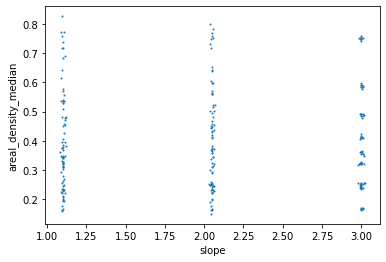

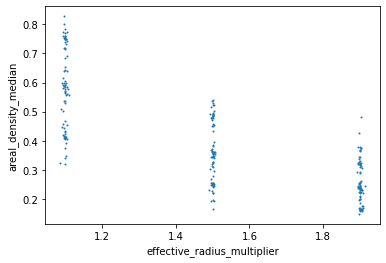

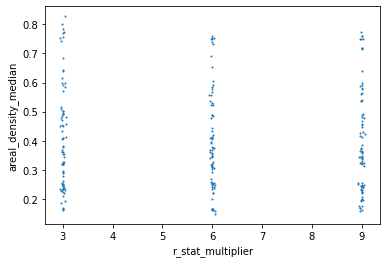

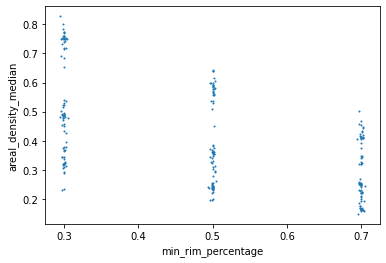

In [4]:
metric = "areal_density_median"
series = stats_df[metric]

for iv in ivs:
    plt.scatter(stats_df[iv], series, s=1)
    plt.xlabel(iv)
    plt.ylabel(metric)
    plt.show()

In [5]:
# Baseline model
model = sm.OLS(stats_df[metric], sm.add_constant(stats_df[ivs]))
result = model.fit()
result.summary()

# plt.hist(result.resid)
# plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     areal_density_median   R-squared:                       0.887
Model:                              OLS   Adj. R-squared:                  0.885
Method:                   Least Squares   F-statistic:                     467.7
Date:                  Wed, 01 Feb 2023   Prob (F-statistic):          1.89e-111
Time:                          16:12:47   Log-Likelihood:                 345.50
No. Observations:                   243   AIC:                            -681.0
Df Residuals:                       238   BIC:                            -663.5
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.3103      0.025     51.938      0.000       1.261       1.360
slope                           0.0011      0.005      0.225      0.822      -0.009       0.011
effective_radius_multiplier    -0.4037      0.012    -34.854      0.000      -0.427      -0.381
r_stat_multiplier              -0.0019      0.002     -1.261      0.209      -0.005       0.001
min_rim_percentage             -0.5935      0.023    -25.604      0.000      -0.639      -0.548
==============================================================================
Omnibus:                        2.878   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.237   Jarque-Bera (JB):                2.840
Skew:                           0.115   Prob(JB):                        0.242
Kurtosis:                       3.477   Cond. No.                         55.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# After stepwise elimination
exclude = {
    metric,
    "r_stat_multiplier",
    "slope"
}
model = sm.OLS(stats_df[metric], sm.add_constant(stats_df[[x for x in ivs if x not in exclude]]))
result = model.fit()
result.summary()

# plt.hist(result.resid)
# plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     areal_density_median   R-squared:                       0.886
Model:                              OLS   Adj. R-squared:                  0.885
Method:                   Least Squares   F-statistic:                     936.1
Date:                  Wed, 01 Feb 2023   Prob (F-statistic):          4.56e-114
Time:                          16:12:47   Log-Likelihood:                 344.67
No. Observations:                   243   AIC:                            -683.3
Df Residuals:                       240   BIC:                            -672.9
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.3009      0.021     61.324      0.000       1.259       1.343
effective_radius_multiplier    -0.4037      0.012    -34.881      0.000      -0.427      -0.381
min_rim_percentage             -0.5935      0.023    -25.625      0.000      -0.639      -0.548
==============================================================================
Omnibus:                        3.370   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.185   Jarque-Bera (JB):                3.675
Skew:                           0.093   Prob(JB):                        0.159
Kurtosis:                       3.573   Cond. No.                         14.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# Adding degree 2 polynomial features
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2)
X = poly_transform.fit_transform(stats_df[ivs])
X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())
X[metric] = stats_df[metric]

In [8]:
# All polynomial features
exclude = {
    metric,
}
model = sm.OLS(stats_df[metric], sm.add_constant(X[[x for x in X.columns if x not in exclude]]))
result = model.fit()
result.summary()

# plt.hist(result.resid)
# plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     areal_density_median   R-squared:                       0.951
Model:                              OLS   Adj. R-squared:                  0.948
Method:                   Least Squares   F-statistic:                     318.2
Date:                  Wed, 01 Feb 2023   Prob (F-statistic):          6.24e-141
Time:                          16:12:47   Log-Likelihood:                 447.65
No. Observations:                   243   AIC:                            -865.3
Df Residuals:                       228   BIC:                            -812.9
Df Model:                            14                                         
Covariance Type:              nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
1                                                  2.5080      0.106     23.700      0.000       2.300       2.717
slope                                              0.0864      0.032      2.734      0.007       0.024       0.149
effective_radius_multiplier                       -1.7481      0.108    -16.245      0.000      -1.960      -1.536
r_stat_multiplier                                 -0.0153      0.010     -1.584      0.115      -0.034       0.004
min_rim_percentage                                -1.7261      0.163    -10.595      0.000      -2.047      -1.405
slope^2                                           -0.0075      0.006     -1.266      0.207      -0.019       0.004
slope effective_radius_multiplier                 -0.0383      0.010     -3.825      0.000      -0.058      -0.019
slope r_stat_multiplier                            0.0013      0.001      0.936      0.350      -0.001       0.004
slope min_rim_percentage                          -0.0083      0.020     -0.412      0.681      -0.048       0.031
effective_radius_multiplier^2                      0.3694      0.034     10.982      0.000       0.303       0.436
effective_radius_multiplier r_stat_multiplier      0.0029      0.003      0.923      0.357      -0.003       0.009
effective_radius_multiplier min_rim_percentage     0.5943      0.048     12.484      0.000       0.500       0.688
r_stat_multiplier^2                                0.0007      0.001      1.096      0.274      -0.001       0.002
r_stat_multiplier min_rim_percentage              -0.0029      0.006     -0.462      0.645      -0.015       0.010
min_rim_percentage^2                               0.2756      0.135      2.046      0.042       0.010       0.541
==============================================================================
Omnibus:                       19.618   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.722
Skew:                           0.077   Prob(JB):                     1.19e-15
Kurtosis:                       5.601   Cond. No.                     4.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
# After stepwise elimination
exclude = {
    metric,
    "r_stat_multiplier min_rim_percentage",
    "slope min_rim_percentage",
    "effective_radius_multiplier r_stat_multiplier",
    "slope r_stat_multiplier",
    "r_stat_multiplier^2",
    "slope^2",
    "r_stat_multiplier",
    "min_rim_percentage^2"
}
model = sm.OLS(stats_df[metric], sm.add_constant(X[[x for x in X.columns if x not in exclude]]))
result = model.fit()
result.summary()

# plt.hist(result.resid)
# plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     areal_density_median   R-squared:                       0.949
Model:                              OLS   Adj. R-squared:                  0.947
Method:                   Least Squares   F-statistic:                     726.5
Date:                  Wed, 01 Feb 2023   Prob (F-statistic):          4.59e-149
Time:                          16:12:47   Log-Likelihood:                 441.15
No. Observations:                   243   AIC:                            -868.3
Df Residuals:                       236   BIC:                            -843.8
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
1                                                  2.4193      0.088     27.374      0.000       2.245       2.593
slope                                              0.0587      0.016      3.776      0.000       0.028       0.089
effective_radius_multiplier                       -1.7318      0.107    -16.190      0.000      -1.943      -1.521
min_rim_percentage                                -1.4854      0.074    -20.145      0.000      -1.631      -1.340
slope effective_radius_multiplier                 -0.0382      0.010     -3.778      0.000      -0.058      -0.018
effective_radius_multiplier^2                      0.3697      0.034     10.888      0.000       0.303       0.437
effective_radius_multiplier min_rim_percentage     0.5943      0.048     12.367      0.000       0.500       0.689
==============================================================================
Omnibus:                       19.207   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.042
Skew:                           0.072   Prob(JB):                     4.56e-15
Kurtosis:                       5.550   Cond. No.                         284.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""